In [ ]:
import torch
from torch import nn
import numpy as np
import pandas as pd
torch.__version__

'2.0.1+cu118'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
X[:5], y[:5]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]),
 array([0, 0, 0, 0, 0]))

In [ ]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [ ]:
data = pd.DataFrame(X, columns= iris.feature_names)
data['Target'] = y
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
class_names = iris.target_names
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
num_features = len(X[0])

print(f"Number of input features: {num_features}")
print(f"Number of classes are: {len(class_names)}")

Number of input features: 4
Number of classes are: 3


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 17)
X_train[:5]

array([[4.7, 3.2, 1.6, 0.2],
       [5.1, 2.5, 3. , 1.1],
       [4.9, 3.6, 1.4, 0.1],
       [5.4, 3.9, 1.7, 0.4],
       [5.5, 2.4, 3.7, 1. ]])

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

accuracy_fn = Accuracy(task= 'multiclass', num_classes= len(class_names)).to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 6.7 MB/s eta 0:00:00


## Building the model

In [ ]:
class RandNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features= input_shape, out_features= hidden_units),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Linear(in_features= hidden_units, out_features= output_shape),
        )

    def forward(self, x):
        return self.linear_layer(x)

In [ ]:
def train_loop(model, X_train, y_train, loss_fn, optimizer, accuracy_fn, device= device):
    model.train()
    X_train = torch.from_numpy(X_train).type(torch.float).to(device)
    y_train = torch.from_numpy(y_train).type(torch.int64).to(device)

    y_train_logits = model(X_train)
    y_train_probs = torch.softmax(y_train_logits, dim= 1)
    y_train_preds = torch.argmax(y_train_probs, dim= 1)

    loss = loss_fn(y_train_logits, y_train)
    train_acc = accuracy_fn(y_train_preds, y_train)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    return loss, train_acc

In [ ]:
def test_loop(model, X_test, y_test, loss_fn, accuracy_fn, device= device):
    model.eval()
    with torch.inference_mode():
        X_test = torch.from_numpy(X_test).type(torch.float).to(device)
        y_test = torch.from_numpy(y_test).type(torch.int64).to(device)

        y_test_logits = model(X_test)
        y_test_probs = torch.softmax(y_test_logits, dim= 1)
        y_test_preds = torch.argmax(y_test_probs, dim= 1)

        loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_test_preds, y_test)
    return loss, test_acc

In [ ]:
torch.manual_seed(17)
model_0 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_0.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(), lr= 0.01)

## Using Epochs = 500 and lr = 0.01

In [ ]:
from tqdm import tqdm
epochs = 500

train_loss_500, test_loss_500 = [], []
train_acc_500, test_acc_500 = [], []
for epoch in range(epochs):
    train_loss, train_acc = train_loop(model_0, X_train, y_train, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_loop(model_0, X_test, y_test, loss_fn, accuracy_fn)

    train_loss_500.append(train_loss.detach().numpy())
    test_loss_500.append(test_loss.detach().numpy())

    if (epoch + 1) % 100 == 0:
        train_acc_500.append(train_acc.detach().numpy())
        test_acc_500.append(test_acc.detach().numpy())
        print(f"\nFor epoch: {epoch + 1}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Train accuracy {train_acc}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test accuracy: {test_acc}")


For epoch: 100
Train loss: 1.0664
Train accuracy 0.5416666865348816
Test Loss: 1.1066
Test accuracy: 0.3333333432674408

For epoch: 200
Train loss: 0.9771
Train accuracy 0.6666666865348816
Test Loss: 1.0211
Test accuracy: 0.6000000238418579

For epoch: 300
Train loss: 0.7911
Train accuracy 0.5833333134651184
Test Loss: 0.8495
Test accuracy: 0.46666666865348816

For epoch: 400
Train loss: 0.5910
Train accuracy 0.5666666626930237
Test Loss: 0.6555
Test accuracy: 0.5666666626930237

For epoch: 500
Train loss: 0.4986
Train accuracy 0.675000011920929
Test Loss: 0.5670
Test accuracy: 0.6333333253860474


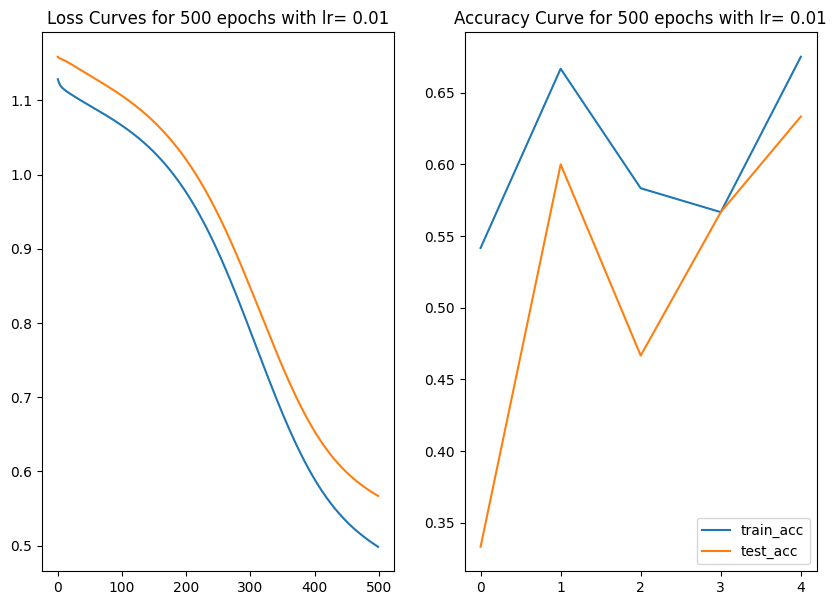

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_500, label= 'train_loss')
ax[0].plot(test_loss_500, label= 'test_loss')

ax[1].plot(train_acc_500, label= 'train_acc')
ax[1].plot(test_acc_500, label= 'test_acc')
ax[0].set_title("Loss Curves for 500 epochs with lr= 0.01")
ax[1].set_title("Accuracy Curve for 500 epochs with lr= 0.01")
plt.legend();

## Epochs = 5000 and lr = 0.01

In [ ]:
torch.manual_seed(17)
model_1 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_1.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_1.parameters(), lr= 0.01)

In [ ]:
from tqdm import tqdm
epochs = 5000

train_loss_5000, test_loss_5000 = [], []
train_acc_5000, test_acc_5000 = [], []
for epoch in range(epochs):
    train_loss, train_acc = train_loop(model_1, X_train, y_train, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_loop(model_1, X_test, y_test, loss_fn, accuracy_fn)

    train_loss_5000.append(train_loss.detach().numpy())
    test_loss_5000.append(test_loss.detach().numpy())
    if (epoch + 1) % 500 == 0:
        train_acc_5000.append(train_acc.detach().numpy())
        test_acc_5000.append(test_acc.detach().numpy())
        print(f"\nFor epoch: {epoch + 1}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Train accuracy {train_acc}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test accuracy: {test_acc}")


For epoch: 500
Train loss: 0.4986
Train accuracy 0.675000011920929
Test Loss: 0.5670
Test accuracy: 0.6333333253860474

For epoch: 1000
Train loss: 0.3636
Train accuracy 0.8416666388511658
Test Loss: 0.4365
Test accuracy: 0.800000011920929

For epoch: 1500
Train loss: 0.1672
Train accuracy 0.9750000238418579
Test Loss: 0.2342
Test accuracy: 1.0

For epoch: 2000
Train loss: 0.0907
Train accuracy 0.9750000238418579
Test Loss: 0.1407
Test accuracy: 1.0

For epoch: 2500
Train loss: 0.0725
Train accuracy 0.9833333492279053
Test Loss: 0.1144
Test accuracy: 0.9666666388511658

For epoch: 3000
Train loss: 0.0649
Train accuracy 0.9833333492279053
Test Loss: 0.1032
Test accuracy: 0.9666666388511658

For epoch: 3500
Train loss: 0.0607
Train accuracy 0.9916666746139526
Test Loss: 0.0973
Test accuracy: 0.9666666388511658

For epoch: 4000
Train loss: 0.0580
Train accuracy 0.9916666746139526
Test Loss: 0.0938
Test accuracy: 0.9666666388511658

For epoch: 4500
Train loss: 0.0560
Train accuracy 0.9916

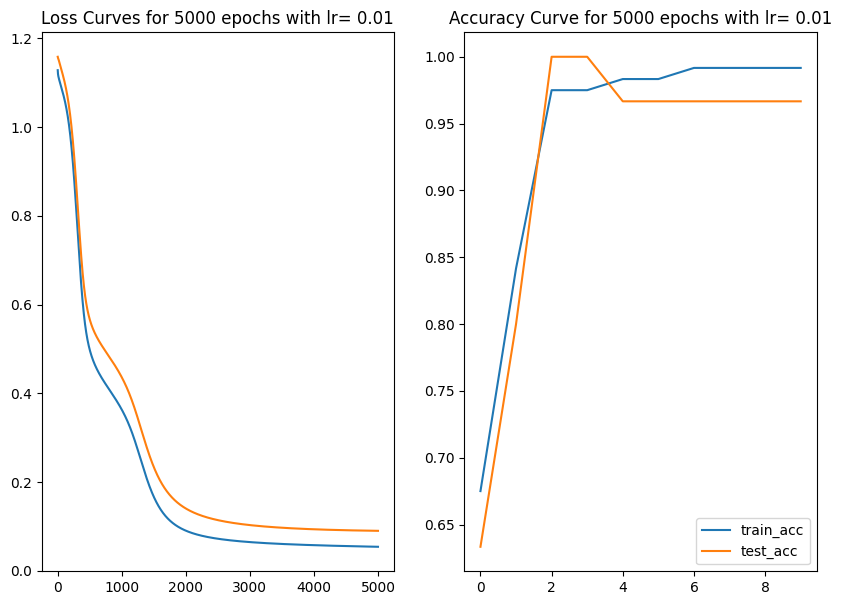

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_5000, label= 'train_loss')
ax[0].plot(test_loss_5000, label= 'test_loss')

ax[1].plot(train_acc_5000, label= 'train_acc')
ax[1].plot(test_acc_5000, label= 'test_acc')
ax[0].set_title("Loss Curves for 5000 epochs with lr= 0.01")
ax[1].set_title("Accuracy Curve for 5000 epochs with lr= 0.01")
plt.legend();

## Using epochs = 500 and lr = 0.1

In [ ]:
torch.manual_seed(17)
model_2 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_2.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_2.parameters(), lr= 0.1)

In [ ]:
epochs = 500

train_loss_500, test_loss_500 = [], []
train_acc_500, test_acc_500 = [], []
for epoch in range(epochs):
    train_loss, train_acc = train_loop(model_2, X_train, y_train, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_loop(model_2, X_test, y_test, loss_fn, accuracy_fn)

    train_loss_500.append(train_loss.detach().numpy())
    test_loss_500.append(test_loss.detach().numpy())
    if (epoch + 1) % 100 == 0:
        train_acc_500.append(train_acc.detach().numpy())
        test_acc_500.append(test_acc.detach().numpy())
        print(f"\nFor epoch: {epoch + 1}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Train accuracy {train_acc}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test accuracy: {test_acc}")


For epoch: 100
Train loss: 0.3691
Train accuracy 0.800000011920929
Test Loss: 0.4398
Test accuracy: 0.800000011920929

For epoch: 200
Train loss: 0.1433
Train accuracy 0.9750000238418579
Test Loss: 0.2038
Test accuracy: 1.0

For epoch: 300
Train loss: 0.1154
Train accuracy 0.9666666388511658
Test Loss: 0.1604
Test accuracy: 0.9666666388511658

For epoch: 400
Train loss: 0.0835
Train accuracy 0.9833333492279053
Test Loss: 0.1352
Test accuracy: 1.0

For epoch: 500
Train loss: 0.2161
Train accuracy 0.925000011920929
Test Loss: 0.8047
Test accuracy: 0.7333333492279053


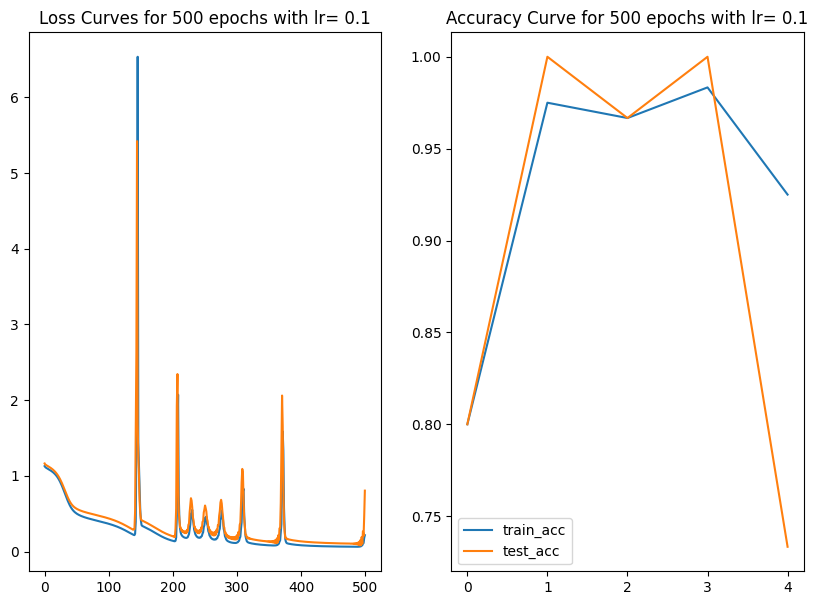

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_500, label= 'train_loss')
ax[0].plot(test_loss_500, label= 'test_loss')

ax[1].plot(train_acc_500, label= 'train_acc')
ax[1].plot(test_acc_500, label= 'test_acc')
ax[0].set_title("Loss Curves for 500 epochs with lr= 0.1")
ax[1].set_title("Accuracy Curve for 500 epochs with lr= 0.1")
plt.legend();

## Using epochs = 5000 and lr = 0.1

In [ ]:
torch.manual_seed(17)
model_3 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_3.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_3.parameters(), lr= 0.1)

In [ ]:
epochs = 5000

train_loss_5000, test_loss_5000 = [], []
train_acc_5000, test_acc_5000 = [], []
for epoch in range(epochs):
    train_loss, train_acc = train_loop(model_3, X_train, y_train, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_loop(model_3, X_test, y_test, loss_fn, accuracy_fn)


    if (epoch + 1) % 300 == 0:
        train_loss_5000.append(train_loss.detach().numpy())
        test_loss_5000.append(test_loss.detach().numpy())
        train_acc_5000.append(train_acc.detach().numpy())
        test_acc_5000.append(test_acc.detach().numpy())
    if (epoch + 1) % 500 == 0:
        print(f"\nFor epoch: {epoch + 1}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Train accuracy {train_acc}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test accuracy: {test_acc}")


For epoch: 500
Train loss: 0.2161
Train accuracy 0.925000011920929
Test Loss: 0.8047
Test accuracy: 0.7333333492279053

For epoch: 1000
Train loss: 0.0529
Train accuracy 0.9916666746139526
Test Loss: 0.0910
Test accuracy: 0.9666666388511658

For epoch: 1500
Train loss: 0.0572
Train accuracy 0.9750000238418579
Test Loss: 0.1421
Test accuracy: 0.8999999761581421

For epoch: 2000
Train loss: 0.0536
Train accuracy 0.9750000238418579
Test Loss: 0.1452
Test accuracy: 0.8999999761581421

For epoch: 2500
Train loss: 0.0512
Train accuracy 0.9750000238418579
Test Loss: 0.1510
Test accuracy: 0.8999999761581421

For epoch: 3000
Train loss: 0.0493
Train accuracy 0.9833333492279053
Test Loss: 0.1572
Test accuracy: 0.8999999761581421

For epoch: 3500
Train loss: 0.0476
Train accuracy 0.9833333492279053
Test Loss: 0.1631
Test accuracy: 0.8999999761581421

For epoch: 4000
Train loss: 0.0462
Train accuracy 0.9833333492279053
Test Loss: 0.1683
Test accuracy: 0.8999999761581421

For epoch: 4500
Train los

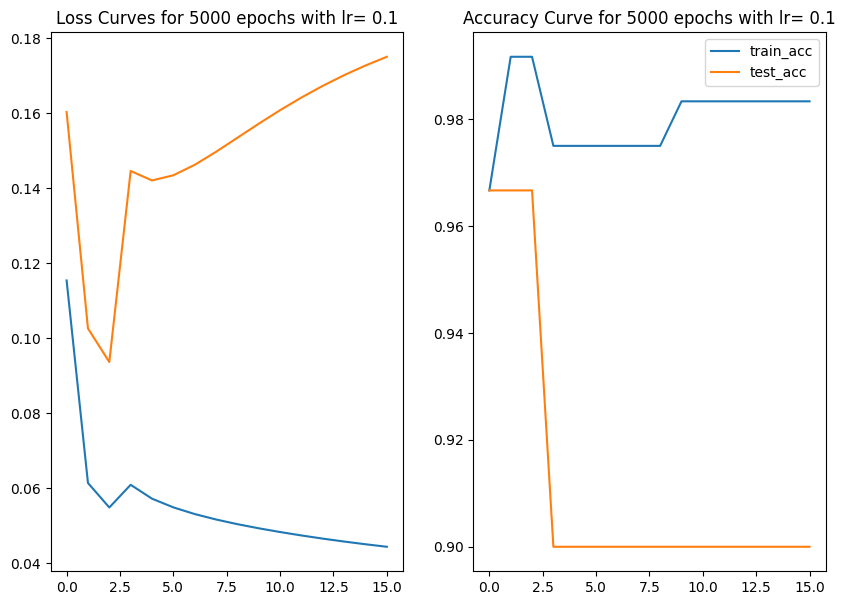

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_5000, label= 'train_loss')
ax[0].plot(test_loss_5000, label= 'test_loss')

ax[1].plot(train_acc_5000, label= 'train_acc')
ax[1].plot(test_acc_5000, label= 'test_acc')
ax[0].set_title("Loss Curves for 5000 epochs with lr= 0.1")
ax[1].set_title("Accuracy Curve for 5000 epochs with lr= 0.1")
plt.legend();

## Using epochs = 500 and lr = 0.2

In [ ]:
torch.manual_seed(17)
model_4 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_4.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_4.parameters(), lr= 0.2)

In [ ]:
epochs = 500

train_loss_500, test_loss_500 = [], []
train_acc_500, test_acc_500 = [], []
for epoch in range(epochs):
    train_loss, train_acc = train_loop(model_4, X_train, y_train, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_loop(model_4, X_test, y_test, loss_fn, accuracy_fn)

    train_loss_500.append(train_loss.detach().numpy())
    test_loss_500.append(test_loss.detach().numpy())
    if (epoch + 1) % 100 == 0:
        train_acc_500.append(train_acc.detach().numpy())
        test_acc_500.append(test_acc.detach().numpy())
        print(f"\nFor epoch: {epoch + 1}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Train accuracy {train_acc}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test accuracy: {test_acc}")


For epoch: 100
Train loss: 0.3812
Train accuracy 0.7666666507720947
Test Loss: 0.5273
Test accuracy: 0.6333333253860474

For epoch: 200
Train loss: 0.3129
Train accuracy 0.800000011920929
Test Loss: 0.3642
Test accuracy: 0.7666666507720947

For epoch: 300
Train loss: 0.1695
Train accuracy 0.9333333373069763
Test Loss: 0.2350
Test accuracy: 0.8333333134651184

For epoch: 400
Train loss: 0.1342
Train accuracy 0.9666666388511658
Test Loss: 0.1790
Test accuracy: 1.0

For epoch: 500
Train loss: nan
Train accuracy 0.3583333194255829
Test Loss: nan
Test accuracy: 0.23333333432674408


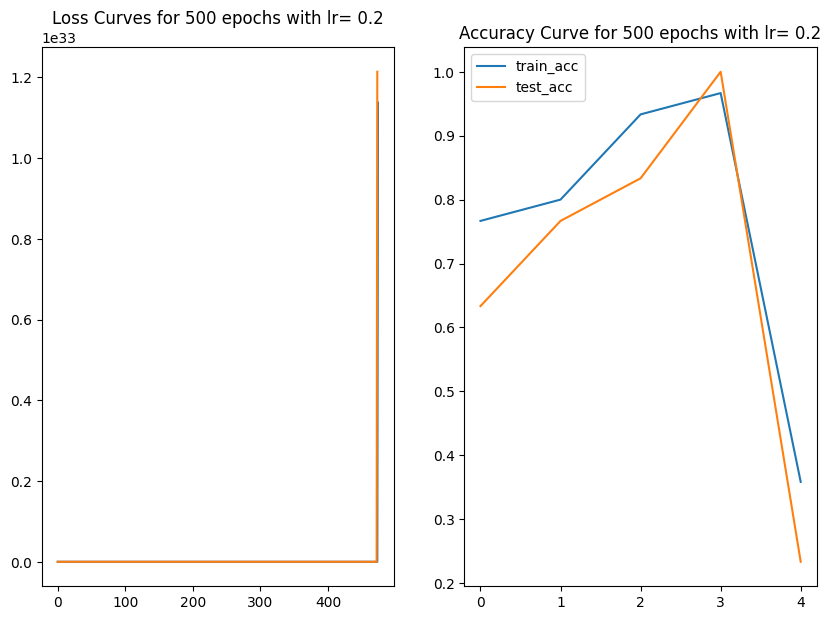

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_500, label= 'train_loss')
ax[0].plot(test_loss_500, label= 'test_loss')

ax[1].plot(train_acc_500, label= 'train_acc')
ax[1].plot(test_acc_500, label= 'test_acc')
ax[0].set_title("Loss Curves for 500 epochs with lr= 0.2")
ax[1].set_title("Accuracy Curve for 500 epochs with lr= 0.2")
plt.legend();

## Using epochs = 5000 and lr = 0.2

In [ ]:
torch.manual_seed(17)
model_5 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_5.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_5.parameters(), lr= 0.2)

In [ ]:
epochs = 5000

train_loss_5000, test_loss_5000 = [], []
train_acc_5000, test_acc_5000 = [], []
for epoch in range(epochs):
    train_loss, train_acc = train_loop(model_5, X_train, y_train, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_loop(model_5, X_test, y_test, loss_fn, accuracy_fn)


    if (epoch + 1) % 100 == 0:
        train_loss_5000.append(train_loss.detach().numpy())
        test_loss_5000.append(test_loss.detach().numpy())
        train_acc_5000.append(train_acc.detach().numpy())
        test_acc_5000.append(test_acc.detach().numpy())
    # if (epoch + 1) % 500 == 0:
    #     print(f"\nFor epoch: {epoch + 1}")
    #     print(f"Train loss: {train_loss:.4f}")
    #     print(f"Train accuracy {train_acc}")
    #     print(f"Test Loss: {test_loss:.4f}")
    #     print(f"Test accuracy: {test_acc}")

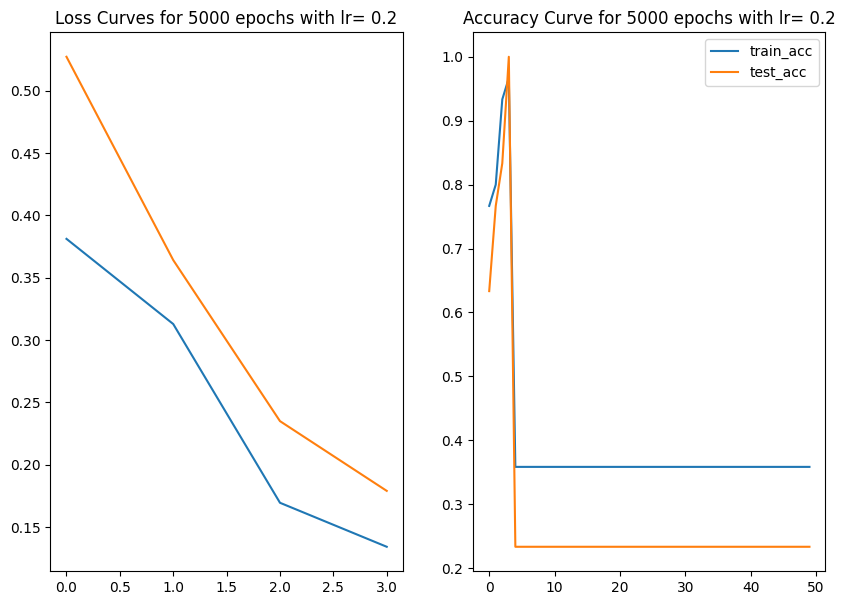

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_5000, label= 'train_loss')
ax[0].plot(test_loss_5000, label= 'test_loss')

ax[1].plot(train_acc_5000, label= 'train_acc')
ax[1].plot(test_acc_5000, label= 'test_acc')
ax[0].set_title("Loss Curves for 5000 epochs with lr= 0.2")
ax[1].set_title("Accuracy Curve for 5000 epochs with lr= 0.2")
plt.legend();

## Functionising the above blocks of code for better understanding

In [ ]:
def train(epochs, model, lr, step, X_train= X_train, y_train= y_train, X_test= X_test, y_test= y_test, accuracy_fn= accuracy_fn):
    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr= lr)

    epochs = epochs

    train_loss_total, test_loss_total = [], []
    train_acc_total, test_acc_total = [], []
    for epoch in range(epochs):
        train_loss, train_acc = train_loop(model, X_train, y_train, loss_fn, optimizer, accuracy_fn)
        test_loss, test_acc = test_loop(model, X_test, y_test, loss_fn, accuracy_fn)


        if (epoch + 1) % step == 0:
            train_loss_total.append(train_loss.detach().numpy())
            test_loss_total.append(test_loss.detach().numpy())
            train_acc_total.append(train_acc.detach().numpy())
            test_acc_total.append(test_acc.detach().numpy())

    return train_loss_total, test_loss_total, train_acc_total, test_acc_total

## Using epochs = 500 and lr = 0.3

In [ ]:
torch.manual_seed(17)
model_6 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_6.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
train_loss_500, test_loss_500, train_acc_500, test_acc_500 = train(epochs= 500,
                                                                   model= model_6,
                                                                   lr= 0.3,
                                                                   step= 23)

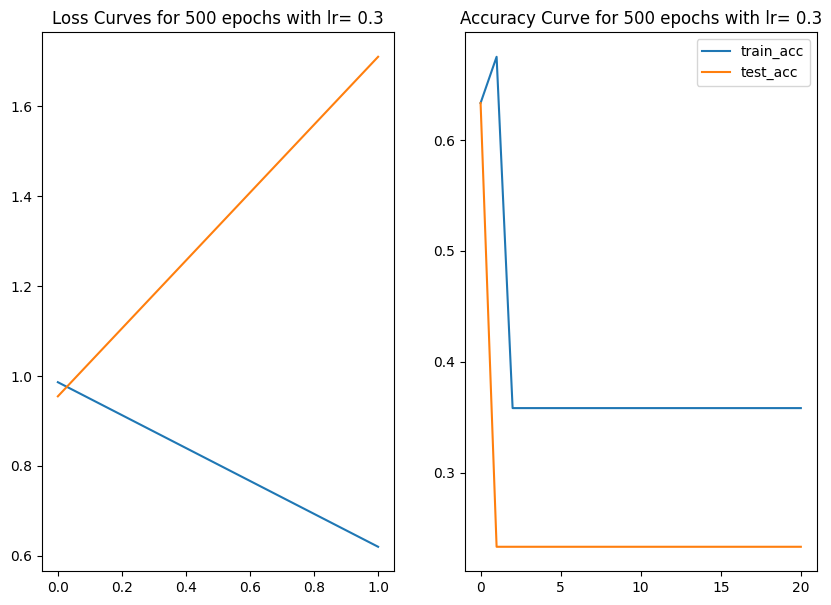

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_500, label= 'train_loss')
ax[0].plot(test_loss_500, label= 'test_loss')

ax[1].plot(train_acc_500, label= 'train_acc')
ax[1].plot(test_acc_500, label= 'test_acc')
ax[0].set_title("Loss Curves for 500 epochs with lr= 0.3")
ax[1].set_title("Accuracy Curve for 500 epochs with lr= 0.3")
plt.legend();

## Using epochs = 5000 and lr = 0.3

In [ ]:
torch.manual_seed(17)
model_7 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_7.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
train_loss_5000, test_loss_5000, train_acc_5000, test_acc_5000 = train(epochs= 5000,
                                                                   model= model_7,
                                                                   lr= 0.3, step= 24)

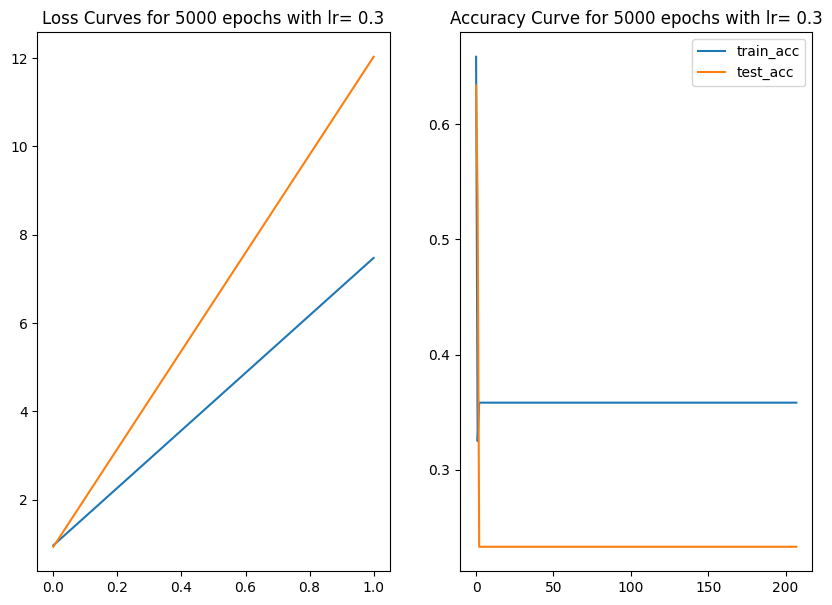

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_5000, label= 'train_loss')
ax[0].plot(test_loss_5000, label= 'test_loss')

ax[1].plot(train_acc_5000, label= 'train_acc')
ax[1].plot(test_acc_5000, label= 'test_acc')
ax[0].set_title("Loss Curves for 5000 epochs with lr= 0.3")
ax[1].set_title("Accuracy Curve for 5000 epochs with lr= 0.3")
plt.legend();

## Using epochs = 500 and lr = 0.4

In [ ]:
torch.manual_seed(17)
model_8 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_8.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
train_loss_500, test_loss_500, train_acc_500, test_acc_500 = train(epochs= 500,
                                                                   model= model_8,
                                                                   lr= 0.4,
                                                                   step= 5)

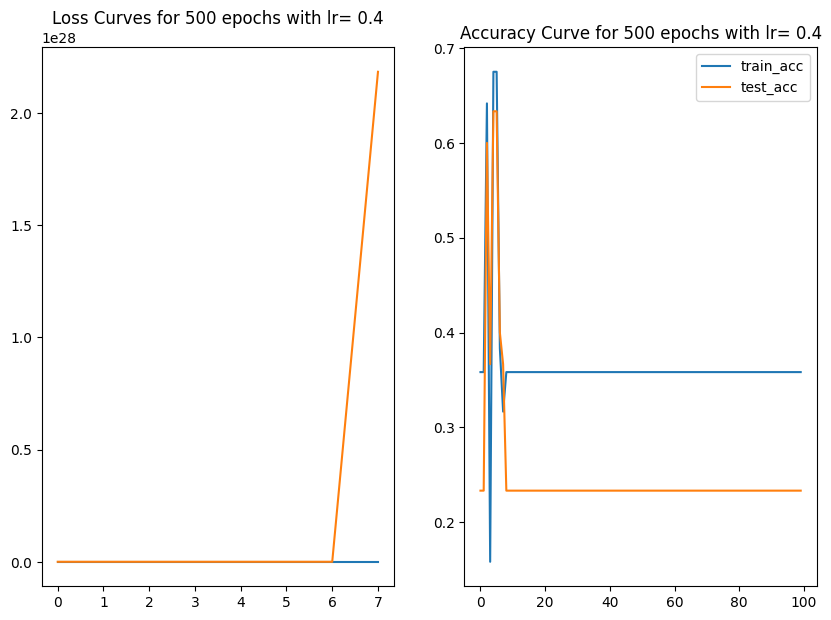

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_500, label= 'train_loss')
ax[0].plot(test_loss_500, label= 'test_loss')

ax[1].plot(train_acc_500, label= 'train_acc')
ax[1].plot(test_acc_500, label= 'test_acc')
ax[0].set_title("Loss Curves for 500 epochs with lr= 0.4")
ax[1].set_title("Accuracy Curve for 500 epochs with lr= 0.4")
plt.legend();

## Using epochs= 5000 and lr= 0.4

In [ ]:
torch.manual_seed(17)
model_9 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_9.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
train_loss_5000, test_loss_5000, train_acc_5000, test_acc_5000 = train(epochs= 5000,
                                                                   model= model_9,
                                                                   lr= 0.4, step= 7)

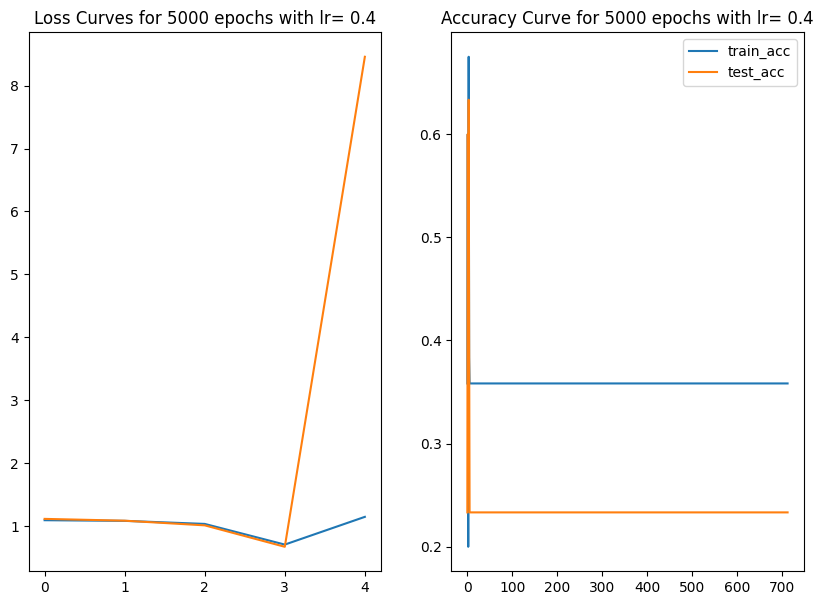

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_5000, label= 'train_loss')
ax[0].plot(test_loss_5000, label= 'test_loss')

ax[1].plot(train_acc_5000, label= 'train_acc')
ax[1].plot(test_acc_5000, label= 'test_acc')
ax[0].set_title("Loss Curves for 5000 epochs with lr= 0.4")
ax[1].set_title("Accuracy Curve for 5000 epochs with lr= 0.4")
plt.legend();

## Using epochs= 500 and lr= 0.5

In [ ]:
torch.manual_seed(17)
model_10 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_10.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
train_loss_500, test_loss_500, train_acc_500, test_acc_500 = train(epochs= 500,
                                                                   model= model_10,
                                                                   lr= 0.5,
                                                                   step= 1)

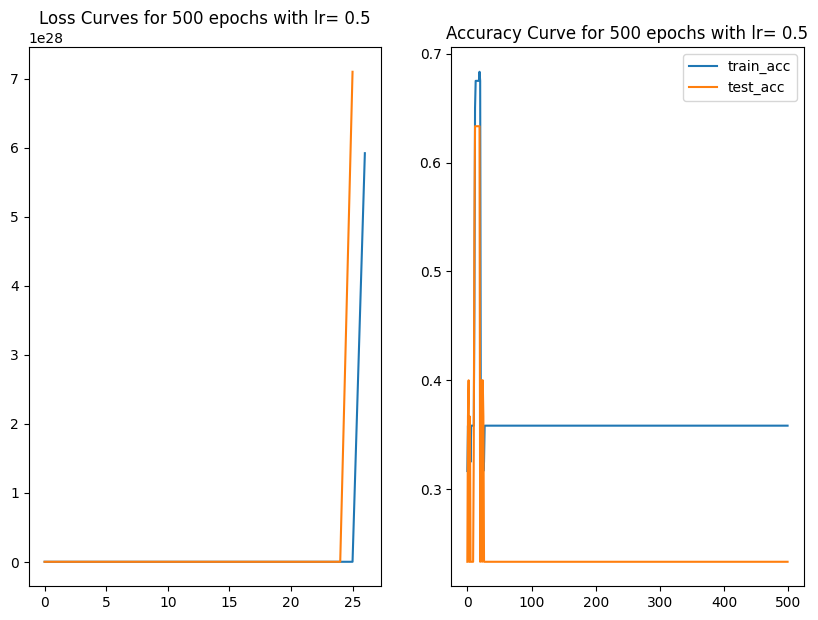

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_500, label= 'train_loss')
ax[0].plot(test_loss_500, label= 'test_loss')

ax[1].plot(train_acc_500, label= 'train_acc')
ax[1].plot(test_acc_500, label= 'test_acc')
ax[0].set_title("Loss Curves for 500 epochs with lr= 0.5")
ax[1].set_title("Accuracy Curve for 500 epochs with lr= 0.5")
plt.legend();

## Using epochs= 5000 and lr= 0.5

In [ ]:
torch.manual_seed(17)
model_11 = RandNN(input_shape= num_features, hidden_units= 2, output_shape= len(class_names))
model_11.to(device)

RandNN(
  (linear_layer): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
train_loss_5000, test_loss_5000, train_acc_5000, test_acc_5000 = train(epochs= 5000,
                                                                   model= model_11,
                                                                   lr= 0.5, step= 2)

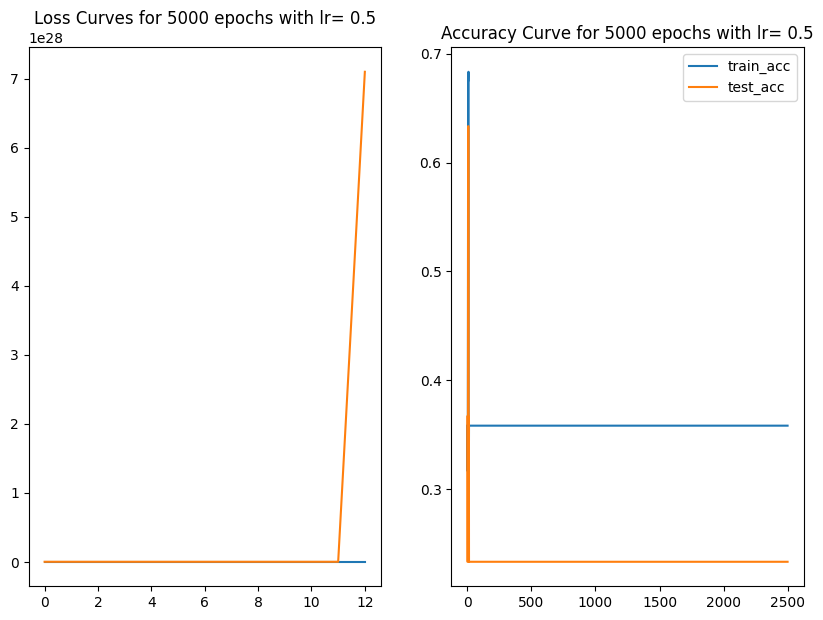

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), nrows= 1, ncols= 2)
ax[0].plot(train_loss_5000, label= 'train_loss')
ax[0].plot(test_loss_5000, label= 'test_loss')

ax[1].plot(train_acc_5000, label= 'train_acc')
ax[1].plot(test_acc_5000, label= 'test_acc')
ax[0].set_title("Loss Curves for 5000 epochs with lr= 0.5")
ax[1].set_title("Accuracy Curve for 5000 epochs with lr= 0.5")
plt.legend();

## Results

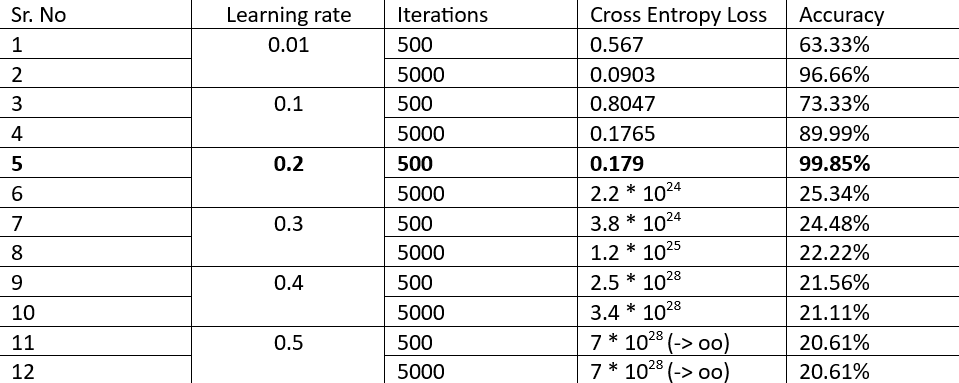

## Conclusion
* The best output is for the model with lr= 0.2 and trained for 500 epochs
* As the lr rises above 0.2 the model starts overshooting and this increases the loss
* We can see the exploding gradients problem here
* Numbers in lr = 0.5 aren't the actual values as the values are tending to infinity